# Анализ групп

В наличии данные с '2023-04-24' по '2023-04-30', 2 пары групп: 
- 1 и 2, где 1 - контрольная, 2 - экспериментальная  
- 0 и 3, где 0 - контрольная, 3 - экспериментальная 

Задача: 

- Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

- Проанализовать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?


# 1 Подгрузка данных 

In [2]:
#импорт библиотек
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandahouse as ph
#делает хеш
import hashlib
from scipy import stats
from scipy.stats import mannwhitneyu

In [3]:
#коннект к БД
connection = {
    'host': '***',
    'password': '***',
    'user': '***',
    'database': '***'
}

In [4]:
#запрос к БД
query = '''
SELECT exp_group,
       user_id,
       countIf(action = 'like') likes,
       countIf(action = 'view') views,
       likes/views ctr
FROM simulator_20230520.feed_actions
WHERE time::DATE BETWEEN '2023-05-01' AND '2023-05-07'
GROUP BY exp_group, user_id
'''

In [5]:
# присваивание полученных данных датафрейму
df = ph.read_clickhouse(query, connection=connection)

In [6]:
#чек
df.head(10)

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,4,107323,5,31,0.161290
5,2,32420,26,128,0.203125
6,2,24239,40,90,0.444444
7,0,30319,21,110,0.190909
8,1,27443,2,29,0.068966
9,3,118359,7,38,0.184211


# Группы 0 и 3

In [11]:
#срез по группам
df1 = df[(df.exp_group == 0) | (df.exp_group == 3)]

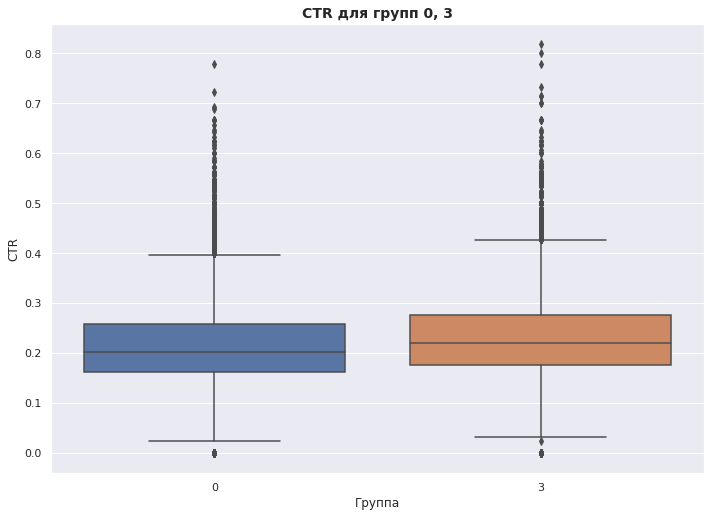

In [13]:
#боксплот
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x ='exp_group', y='ctr', data=df1)
plt.xlabel('Группа')
plt.ylabel('CTR')
plt.title('CTR для групп 0, 3', fontweight='bold', fontsize=14)
plt.show()

In [25]:
#t test 
stat1, pvalue1 = stats.ttest_ind(df1[df1.exp_group == 0].ctr, df1[df1.exp_group == 3].ctr, equal_var=False)

print('Statistics_ctr=%.3f, p-value_ctr=%.3f' % (stat1, pvalue1))

Statistics_ctr=-13.897, p-value_ctr=0.000


### расчёт линеаризованных лайков

In [18]:
#расчёт параметра ctr_control
ctr_control = df1[df1.exp_group == 0].likes.sum()/df1[df1.exp_group == 0].views.sum()
ctr_control

0.20823612262916305

In [20]:
#расчёт метрики linearized_likes
df1 = df1.copy()
df1['linearized_likes'] = df1.likes - ctr_control*df1.views

In [23]:
#чек
df1.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
2,3,123580,13,48,0.270833,3.004666
7,0,30319,21,110,0.190909,-1.905973
9,3,118359,7,38,0.184211,-0.912973
11,0,7626,14,39,0.358974,5.878791


### тест

In [26]:
#t test 
stat2, pvalue2 = stats.ttest_ind(df1[df1.exp_group == 0].linearized_likes, df1[df1.exp_group == 3].linearized_likes, equal_var=False)

print('Statistics_linearized=%.3f, p-value_linearized=%.3f' % (stat2, pvalue2))

Statistics_linearized=-15.215, p-value_linearized=0.000


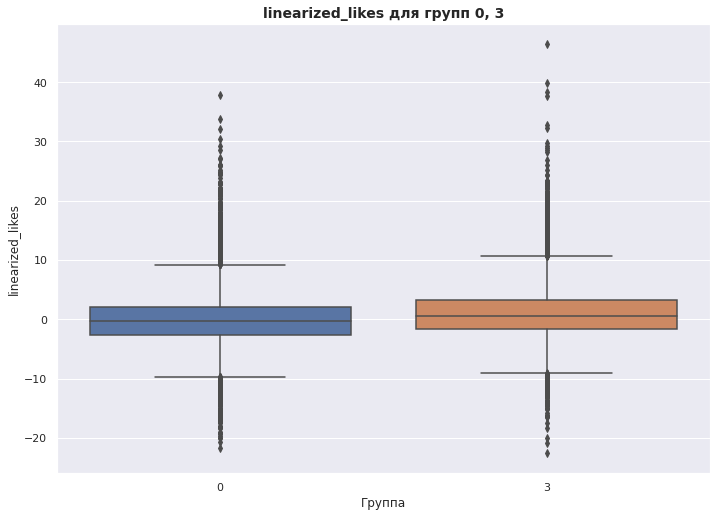

In [38]:
#визуализация linearized_likes
sns.boxplot(x ='exp_group', y='linearized_likes', data=df1)
plt.xlabel('Группа')
plt.ylabel('linearized_likes')
plt.title('linearized_likes для групп 0, 3', fontweight='bold', fontsize=14)
plt.show()

### Вывод

Метод linearized_likes, в сравнении с CTR показал меньший показатель t статистики, p value в обоих случаях - 0.000, что значит вероятность получения таких или более экстремальных результатов случайно равна 0.

# Группы 1 и 2

In [28]:
#срез по группам
df2 = df[(df.exp_group == 1) | (df.exp_group == 2)]

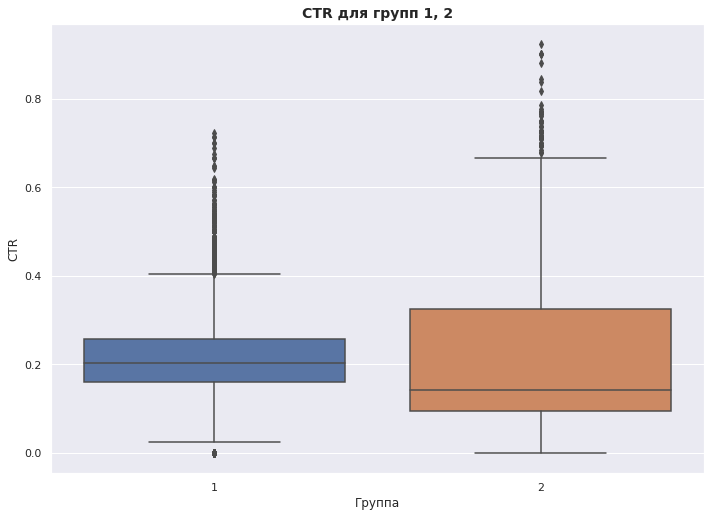

In [37]:
#боксплот
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x ='exp_group', y='ctr', data=df2)
plt.xlabel('Группа')
plt.ylabel('CTR')
plt.title('CTR для групп 1, 2', fontweight='bold', fontsize=14)
plt.show()

In [30]:
#t test 
stat1, pvalue1 = stats.ttest_ind(df2[df2.exp_group == 1].ctr, df2[df2.exp_group == 2].ctr, equal_var=False)

print('Statistics_ctr=%.3f, p-value_ctr=%.3f' % (stat1, pvalue1))

Statistics_ctr=0.709, p-value_ctr=0.478


### расчёт линеаризованных лайков

In [31]:
#расчёт параметра ctr_control
ctr_control2 = df2[df2.exp_group == 1].likes.sum()/df2[df2.exp_group == 1].views.sum()
ctr_control2

0.20802680490126244

In [32]:
#расчёт метрики linearized_likes
df2 = df2.copy()
df2['linearized_likes'] = df2.likes - ctr_control2*df2.views

In [33]:
#чек
df2.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
1,1,18392,7,32,0.218750,0.343142
3,2,131473,14,134,0.104478,-13.875592
5,2,32420,26,128,0.203125,-0.627431
6,2,24239,40,90,0.444444,21.277588
8,1,27443,2,29,0.068966,-4.032777


### тест

In [34]:
#t test 
stat2, pvalue2 = stats.ttest_ind(df2[df2.exp_group == 1].linearized_likes, df2[df2.exp_group == 2].linearized_likes, equal_var=False)

print('Statistics_linearized=%.3f, p-value_linearized=%.3f' % (stat2, pvalue2))

Statistics_linearized=6.123, p-value_linearized=0.000


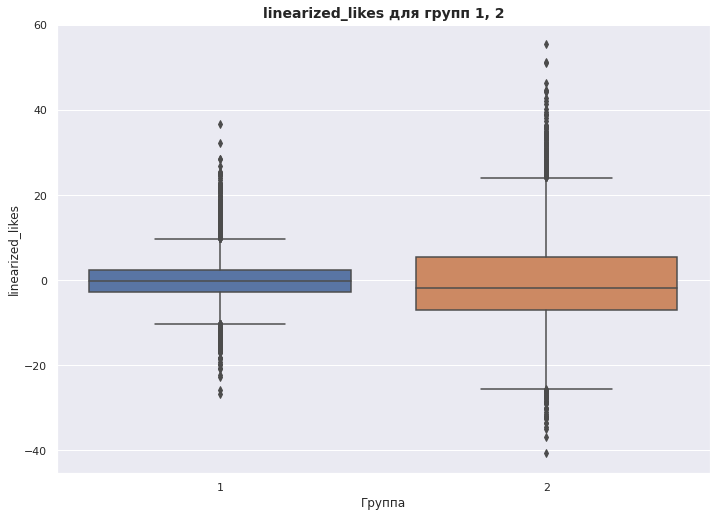

In [36]:
#визуализация linearized_likes
sns.boxplot(x ='exp_group', y='linearized_likes', data=df2)
plt.xlabel('Группа')
plt.ylabel('linearized_likes')
plt.title('linearized_likes для групп 1, 2', fontweight='bold', fontsize=14)
plt.show()

### Вывод

P value изменился с 0.478 до 0.000, что значит вероятность получения таких или более экстремальных результатов случайно равна 0. Форма распределиния признака CTR во второй группе имеет ассиметрию, после преобразования метрика linearized_likes имеет близкое к нормальному распределение, что позволит t-тесту работать более корректно.

# Общий вывод

Метрика CTR находится в диапазоне от 0 до 1, тогда как линеризация позволяет расширить диапазон значений от - значение, до + значение. Линеризованная метрика в обоих случаях имела около нормальное распределение, при том, что метрика CTR в одном из случаев была распределена ассиметрично. Также линеризованная метрика позволяет использовать t-тест с высокой долей надежности.